### Read and analyse TPB data

this notebook currently has the very simple (manual) calibration included. Its expected that the trigger for this sample means the peak is always in the *same location*. If this isn't the case, you need to apply a peak finding algorithm.

In [20]:
import numpy as np
import matplotlib.pyplot as plt

import struct
from tqdm import tqdm
import math as m
import h5py


In [21]:
import pandas as pd
import sys, os

sys.path.append("/home/nulab4/Documents/MULE_WIP/")

from packs.core import io as io


In [22]:
#x = io.load_rwf_info('Calibration/run10.h5', samples = 2)
x = io.load_rwf_info('run19.h5', samples = 2)

/home/nulab4/Documents/MULE_WIP/packs/core/io.py:45: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(file_path) as f:


In [23]:
display(x)
import csv
print(x.event_number.values)
event_numbers = x.event_number.values
data = x.rwf.values


,event_number,channels,rwf
0,0,0,"[8197, 8196, 8193, 8197, 8192, 8197, 8196, 819..."
1,1,0,"[8195, 8200, 8190, 8199, 8194, 8195, 8190, 819..."
2,2,0,"[8193, 8193, 8193, 8194, 8195, 8198, 8190, 819..."
3,3,0,"[8193, 8193, 8197, 8189, 8197, 8194, 8198, 819..."
4,4,0,"[8187, 8200, 8190, 8203, 8195, 8192, 8201, 819..."
...,...,...,...
5033,5033,0,"[8199, 8192, 8196, 8189, 8199, 8192, 8191, 819..."
5034,5034,0,"[8192, 8196, 8192, 8195, 8193, 8194, 8192, 819..."
5035,5035,0,"[8192, 8197, 8191, 8196, 8192, 8198, 8194, 819..."
5036,5036,0,"[8195, 8191, 8194, 8194, 8195, 8198, 8194, 819..."


[   0    1    2 ... 5035 5036 5037]


### Read in event

You should make a function that does this for different events :)

In [24]:
# shape
print(f"Rate of data:\n{len(data)/60}\n")
# event
print(f"In one of those {len(data)} events, 150 samples across time as shown:\n{data[0]}")

Rate of data:
83.96666666666667

In one of those 5038 events, 150 samples across time as shown:
[8197 8196 8193 ... 8202 8192 8198]



### Visualise one event

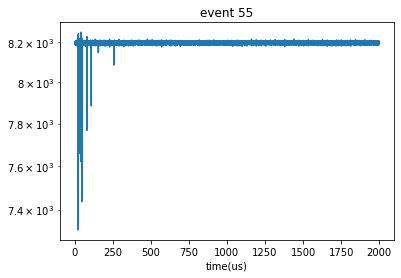

In [25]:
event = 55

length = len(data[event])

# time axis, each sample is 2ns apart, so simple conversion
time = np.linspace(0,length*4*1e-3, num = length)
plt.plot(time, data[event])
plt.title('event ' + str(event))
#plt.xscale('log')
plt.yscale('log')
#plt.xlim(0, 1000)
plt.xlabel('time(us)')
plt.show()

##### Where are we triggering?

Generally, if you plot a bunch of waveforms, you'll see where the trigger is based (data can trigger incorrectly, we'll ignore those)

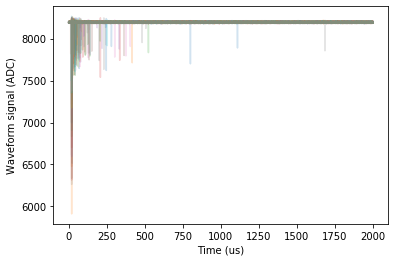

In [26]:
# plot first N waveforms over one another. This will tell us where the trigger is
for i in range(20):
    plt.plot(time, data[i], alpha = 0.2)
plt.xlabel('Time (us)')
plt.ylabel('Waveform signal (ADC)')
#plt.title('200 Waveforms')
#plt.xlim(2.5,3)
#plt.yscale('log')~
#plt.axvline(2.640)
#plt.axvline(2.73)

plt.show()

### now lets process a dataframe

- baseline subtraction
- window selection (start, length)


**SELECT STANDARD PARAMETERS**

/home/nulab4/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


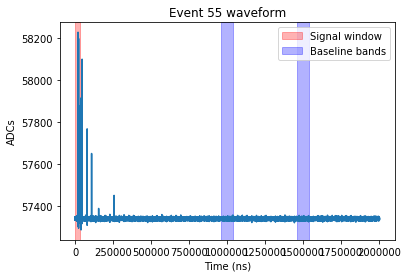

In [27]:
# MISC VALUES
bin_size         = 4              # ns, time spacing between bins
var              = 55              # waveform number for visualising
negative         = True            # flips from negative to positive

# WINDOW VALUES

WINDOW_START     = 4e2               # ns
WINDOW_END       = 3e4          # ns
BASELINE_POINT_1 = 1e6 # ns, DONT SET THIS TO THE MINIMUM (0)
BASELINE_POINT_2 =  1.5e6          # ns, DONT SET THIS TO THE MAXIMUM
BASELINE_RANGE_1  = 40e3              # ns, DONT LET THIS EXCEED THE MINIMUM/MAXIMUM
BASELINE_RANGE_2  = 40e3           # ns, DONT LET THIS EXCEED THE MINIMUM/MAXIMUM

# PACKAGING THE WINDOW VALUES
window_args = [WINDOW_START, WINDOW_END, BASELINE_POINT_1, BASELINE_POINT_2, BASELINE_RANGE_1, BASELINE_RANGE_2]



time = np.linspace(0,len(data[var]), num = len(data[var]), dtype = int)
time = time * bin_size # reshape

if (negative == True):
    plt.plot(time, -data[var])
elif (negative == False):
    plt.plot(time, data[var])
plt.axvspan(WINDOW_START, WINDOW_END, alpha = 0.3, color = 'red', label = 'Signal window')
plt.axvspan(BASELINE_POINT_1 - BASELINE_RANGE_1, BASELINE_POINT_1 + BASELINE_RANGE_1, alpha = 0.3, color = 'blue', label = 'Baseline bands')
plt.axvspan(BASELINE_POINT_2 - BASELINE_RANGE_2, BASELINE_POINT_2 + BASELINE_RANGE_2, alpha = 0.3, color = 'blue')
plt.xlabel('Time (ns)')
plt.ylabel('ADCs')
plt.title(f'Event {var} waveform')
plt.legend()
#plt.xlim(0, 1e1)
#plt.xscale('log')
plt.show()

**DEFINING PROCESSING FUNCTIONS**

In [9]:
def subtract_baseline(y_data, type = 'median'):
    '''
    determines the value that should be subtracted to produce baseline
    '''


    # convert y_data to numpy array for your own sanity
    y_data = np.array(y_data)

    # MEAN METHOD
    # add all ADC values and divide by length (rough), also remove negatives
    if (type=='mean'):
        total = (np.sum(y_data)/len(y_data))
    # MODE METHOD
    elif (type=='mode'):
        value, counts = np.unique(y_data, return_counts=True)
        m = counts.argmax()
        # counteracting mode being stupid
        #if counts[m] == 1:
        #    print("Only one count of this value, please use a different method! (Mode sucks Brais >:( ))")
        #else:
        #    total = value[m]
        total = value[m]
        ## SCIPY IS SLOW!
        ##return (stats.mode(y_data))
    # MEDIAN METHOD
    elif (type=='median'):
        total = np.median(y_data)
    elif (type=='None'):
        total = 0
    else:
        print("Please input a baseline method, exiting...")
        return 0

    # return value to subtract
    return total


def integrate(y_data):
    '''
    collect the integral across an event by summing y components
    '''
    ####print("Baseline subtracted value: {}".format(y_data[25]))
    int_tot = np.sum(y_data)
    return(int_tot)

def peak(y_data) :
    '''
    use the peak instead of the integral
    '''
    amp_peak = np.max(y_data)
    return(amp_peak)


def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or m.fabs(value - array[idx-1]) < m.fabs(value - array[idx])):
        return array[idx-1]
    else:
        return array[idx]

def collect_index(time, value):
    '''
    Collects the array index corresponding to a certain time value

    Args:
        time        (np.array)        :     Time array
        value       (float/int)       :     Value that you wish to locate the index of
    '''
    
    val = find_nearest(time, value)
    index = np.where(time == val)[0]

    if len(index == 1):
        return index[0]
    else:
        raise Exception("Must only collect one index! Are you sure you entered the right array?")


### the meaty function

def cook_data(data, bin_size, window_args, negative = False, baseline_mode = 'median', verbose = 0):
    '''
    Collects the charge histograms from waveform arrays via simple processing
    Spits out tuple containing BL-subtracted waveforms and charge of each signal.

    Args:
        data          (np.array)      :       Waveform data
        bin_size      (float)         :       Size of time bins within data
        window_args   (list)          :       list of window values for use in processing, ordered as such:
                                                     WINDOW_START    
                                                     WINDOW_END      
                                                     BASELINE_POINT_1
                                                     BASELINE_POINT_2
                                                     BASELINE_RANGE_1
                                                     BASELINE_RANGE_2
        negative      (bool)          :       Is the waveform negative? (flips to positive format)
        baseline_mode (string)        :       Mode of the baseline subtraction (median, mode, mean, etc).
        verbose       (int)          :       Print info: 0 is nothing, 1 is barebones, 2 includes plots

    Returns:
        results(
           sub_data   (array)         :       Baseline subtracted waveforms
           Q_data     (array)         :       Charge histogram data per waveform
        )


    '''
    # unpack window arguments
    ### TODO, PACK THIS IN AN ITERATIVE METHOD, THIS IS SILLY
    WINDOW_START     = window_args[0]   
    WINDOW_END       = window_args[1]
    BASELINE_POINT_1 = window_args[2]
    BASELINE_POINT_2 = window_args[3]
    BASELINE_RANGE_1 = window_args[4]  
    BASELINE_RANGE_2 = window_args[5]  

    
    # define time-span
    time = np.linspace(0,len(data[0]), num = len(data[0]), dtype = int) * bin_size
    

    start_index = collect_index(time, WINDOW_START)
    end_index   = collect_index(time, WINDOW_END)

    # make sure ranges dont go ape
    try:
        min_1 = BASELINE_POINT_1 - BASELINE_RANGE_1
        max_1 = BASELINE_POINT_1 + BASELINE_RANGE_1
        min_2 = BASELINE_POINT_2 - BASELINE_RANGE_2
        max_2 = BASELINE_POINT_2 + BASELINE_RANGE_2
        bl_range_1 = [collect_index(time, min_1),collect_index(time, max_1)]
        bl_range_2 = [collect_index(time, min_2),collect_index(time, max_2)]
    except:
        print(f'Range values out of range (lol): {min_1} - {max_1}, {min_2} - {max_2}')

    
    


    if (verbose > 0):
        print(f'{len(data)} events')
        print(f"Collecing sidebands across time ranges {min_1} - {max_1}, {min_2} - {max_2}")
        print(f"Sideband indexes: {bl_range_1[0]} - {bl_range_1[1]}, {bl_range_2[0]} - {bl_range_2[1]}")
        
        

    # currently doing this the lazy way (iteratively), will do it via mapping soon

    sub_data = []
    Q_data   = []
    peak_data = []
    i = 0 # annoying counter
    for wf in data:  # select each event to process
    
        # Make zero values equal to 1
        #threshold = 0
        #substitute = 1
        #wf[wf <= threshold] = substitute
        
        # negative flip
        if (negative == True):
            wf = -wf

        #plot
        if (verbose > 1):

            plt.plot(time, wf)
            plt.axvspan(WINDOW_START, WINDOW_END, alpha = 0.3, color = 'red', label = 'Signal window')
            plt.axvspan(BASELINE_POINT_1 - BASELINE_RANGE_1, BASELINE_POINT_1 + BASELINE_RANGE_1, alpha = 0.3, color = 'blue', label = 'Baseline bands')
            plt.axvspan(BASELINE_POINT_2 - BASELINE_RANGE_2, BASELINE_POINT_2 + BASELINE_RANGE_2, alpha = 0.3, color = 'blue')
            plt.xlabel('Time (ns)')
            plt.ylabel('ADCs')
            plt.title(f'Event {i} waveform')
            plt.legend()
            plt.show()
        
        ### baseline subtraction ###

        # take y values within sidebands, double index is because my formatting is stupid
        y_sideband = wf[bl_range_1[0]:bl_range_1[1]]
        y_sideband = list(y_sideband) + list(wf[bl_range_2[0]:bl_range_2[1]])

        # produce sub_wf
        sub_wf = wf - subtract_baseline(y_sideband, type = baseline_mode)
        
        #Remove negatives
        #threshold_2 = 10
        #substitute_2 = 0
        #sub_wf[sub_wf < threshold_2] = substitute_2

        
        sub_data.append(sub_wf)

        # calculate adc
        adc_val = integrate(sub_wf[start_index:end_index])
        Q_data.append(adc_val)
        peak_val = peak(sub_wf[start_index:end_index])
        peak_data.append(peak_val)
     

        if (verbose > 1):
            plt.plot(time, sub_wf)
            plt.xlabel('Time (us)')
            plt.ylabel('ADCs')
            plt.title(f'Event {i} subtracted waveform')
            plt.show()
        



        if (verbose > 0):
            print(f'Event {i} ADC value: {adc_val}')
           # if peak_val < 600:
            #    print(f'Event {i} has less than 1000 ADC peak')
             #   plt.plot(time, sub_wf)
              #  plt.xlabel('Time (ns)')
               # plt.ylabel('ADCs')
                #plt.yscale('log')
                #plt.title(f'Event {i} subtracted waveform')
                #plt.show()



        i += 1

    return (sub_data, Q_data, peak_data)



**VISUAL DEMONSTRATION**

<class 'numpy.ndarray'>
1 events
Collecing sidebands across time ranges 100.0 - 900.0, 1100.0 - 1900.0
Sideband indexes: 25 - 225, 275 - 475


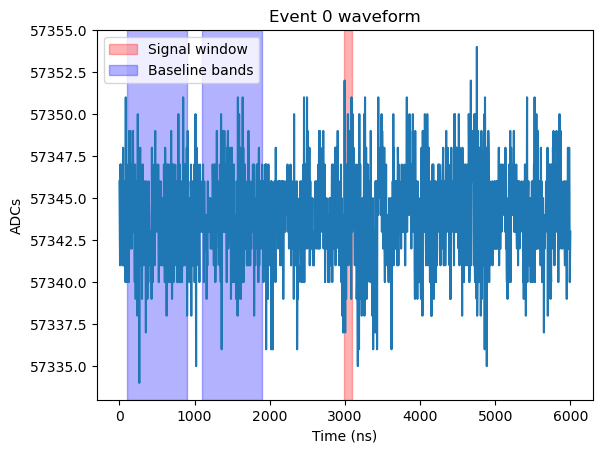

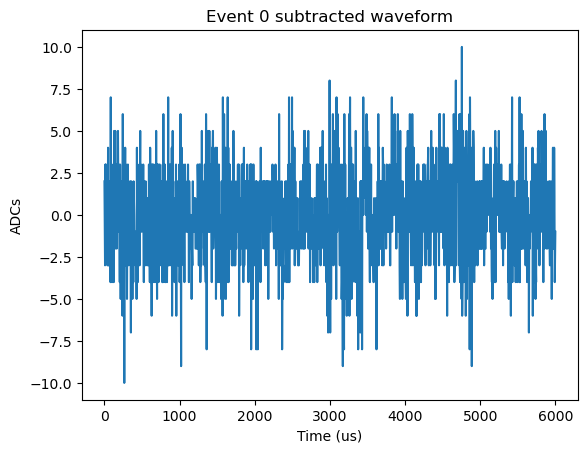

Event 0 ADC value: 20.0


In [10]:

# test dataset
test_data = data
print(type(test_data))



results = cook_data([test_data[1]], bin_size, window_args, negative = negative, baseline_mode = 'median', verbose = 2)

**FULL DATA PROCESSING**

In [11]:
results = cook_data(data[0:150000], bin_size, window_args, negative = negative, baseline_mode = 'median', verbose = 0)
#np.save('ADC_data_100_peak.npy', results[1])


Event 15594 ADC value: 651.0
Event 15595 ADC value: 575.0
Event 15596 ADC value: 898.0
Event 15597 ADC value: 741.0
Event 15598 ADC value: 519.0
Event 15599 ADC value: 196.0
Event 15600 ADC value: 664.0
Event 15601 ADC value: 139.0
Event 15602 ADC value: 826.0
Event 15603 ADC value: 851.0
Event 15604 ADC value: 562.0
Event 15605 ADC value: 207.0
Event 15606 ADC value: 863.0
Event 15607 ADC value: 1186.0
Event 15608 ADC value: 805.0
Event 15609 ADC value: 317.0
Event 15610 ADC value: 439.0
Event 15611 ADC value: 770.0
Event 15612 ADC value: 1089.0
Event 15613 ADC value: 93.0
Event 15614 ADC value: 399.0
Event 15615 ADC value: 722.0
Event 15616 ADC value: 70.0
Event 15617 ADC value: 916.0
Event 15618 ADC value: 999.0
Event 15619 ADC value: 863.0
Event 15620 ADC value: 406.0
Event 15621 ADC value: 786.0
Event 15622 ADC value: 292.0
Event 15623 ADC value: 481.0
Event 15624 ADC value: 158.0
Event 15625 ADC value: 133.0
Event 15626 ADC value: 76.0
Event 15627 ADC value: 358.0
Event 15628 ADC

Event 17050 ADC value: 1057.0
Event 17051 ADC value: 453.0
Event 17052 ADC value: 890.0
Event 17053 ADC value: 1209.0
Event 17054 ADC value: 116.0
Event 17055 ADC value: 1263.0
Event 17056 ADC value: 1334.0
Event 17057 ADC value: 1294.0
Event 17058 ADC value: 725.0
Event 17059 ADC value: 77.0
Event 17060 ADC value: 781.0
Event 17061 ADC value: 105.0
Event 17062 ADC value: 204.0
Event 17063 ADC value: 84.0
Event 17064 ADC value: 609.0
Event 17065 ADC value: 164.0
Event 17066 ADC value: 526.0
Event 17067 ADC value: 746.0
Event 17068 ADC value: 400.0
Event 17069 ADC value: 480.0
Event 17070 ADC value: 784.0
Event 17071 ADC value: 90.0
Event 17072 ADC value: 1141.0
Event 17073 ADC value: 1246.0
Event 17074 ADC value: 829.0
Event 17075 ADC value: 631.0
Event 17076 ADC value: 379.0
Event 17077 ADC value: 627.0
Event 17078 ADC value: 449.0
Event 17079 ADC value: 1011.0
Event 17080 ADC value: 480.0
Event 17081 ADC value: 565.0
Event 17082 ADC value: 509.0
Event 17083 ADC value: 898.0
Event 170

Event 18415 ADC value: 908.0
Event 18416 ADC value: 767.0
Event 18417 ADC value: 568.0
Event 18418 ADC value: 295.0
Event 18419 ADC value: 1455.0
Event 18420 ADC value: 792.0
Event 18421 ADC value: 4083.0
Event 18422 ADC value: 710.0
Event 18423 ADC value: 497.0
Event 18424 ADC value: 232.5
Event 18425 ADC value: 479.0
Event 18426 ADC value: 134.0
Event 18427 ADC value: 79.0
Event 18428 ADC value: 694.0
Event 18429 ADC value: 125.0
Event 18430 ADC value: 403.0
Event 18431 ADC value: 915.0
Event 18432 ADC value: 494.0
Event 18433 ADC value: 802.0
Event 18434 ADC value: 116.0
Event 18435 ADC value: 1070.0
Event 18436 ADC value: 582.0
Event 18437 ADC value: 795.0
Event 18438 ADC value: 307.0
Event 18439 ADC value: 127.0
Event 18440 ADC value: 549.0
Event 18441 ADC value: 855.0
Event 18442 ADC value: 754.0
Event 18443 ADC value: 742.0
Event 18444 ADC value: 194.0
Event 18445 ADC value: 629.0
Event 18446 ADC value: 636.0
Event 18447 ADC value: 768.0
Event 18448 ADC value: 773.0
Event 18449 

Event 19726 ADC value: 255.0
Event 19727 ADC value: 1281.0
Event 19728 ADC value: 120.0
Event 19729 ADC value: 911.0
Event 19730 ADC value: 743.0
Event 19731 ADC value: 99.0
Event 19732 ADC value: 364.0
Event 19733 ADC value: 286.0
Event 19734 ADC value: 352.0
Event 19735 ADC value: 761.0
Event 19736 ADC value: 625.0
Event 19737 ADC value: 671.0
Event 19738 ADC value: 603.0
Event 19739 ADC value: 1040.0
Event 19740 ADC value: 622.0
Event 19741 ADC value: 222.0
Event 19742 ADC value: 254.0
Event 19743 ADC value: 460.0
Event 19744 ADC value: 448.0
Event 19745 ADC value: 765.0
Event 19746 ADC value: 816.0
Event 19747 ADC value: 1173.0
Event 19748 ADC value: 364.0
Event 19749 ADC value: 575.0
Event 19750 ADC value: 595.0
Event 19751 ADC value: 338.0
Event 19752 ADC value: 1258.0
Event 19753 ADC value: 774.0
Event 19754 ADC value: 1686.0
Event 19755 ADC value: 78.0
Event 19756 ADC value: 902.0
Event 19757 ADC value: 392.0
Event 19758 ADC value: 218.0
Event 19759 ADC value: 979.0
Event 19760

Event 21252 ADC value: 492.0
Event 21253 ADC value: 487.0
Event 21254 ADC value: 455.0
Event 21255 ADC value: 848.0
Event 21256 ADC value: 799.0
Event 21257 ADC value: 928.0
Event 21258 ADC value: 237.0
Event 21259 ADC value: 73.0
Event 21260 ADC value: 283.0
Event 21261 ADC value: 205.0
Event 21262 ADC value: 1204.0
Event 21263 ADC value: 645.0
Event 21264 ADC value: 279.0
Event 21265 ADC value: 1271.0
Event 21266 ADC value: 835.0
Event 21267 ADC value: 1023.5
Event 21268 ADC value: 1319.0
Event 21269 ADC value: 595.0
Event 21270 ADC value: 848.0
Event 21271 ADC value: 1145.0
Event 21272 ADC value: 339.0
Event 21273 ADC value: 994.0
Event 21274 ADC value: 544.0
Event 21275 ADC value: 91.0
Event 21276 ADC value: 1209.0
Event 21277 ADC value: 1085.0
Event 21278 ADC value: 60.0
Event 21279 ADC value: 331.0
Event 21280 ADC value: 806.0
Event 21281 ADC value: 804.0
Event 21282 ADC value: 1235.0
Event 21283 ADC value: 795.0
Event 21284 ADC value: 426.0
Event 21285 ADC value: 199.0
Event 212

Event 22659 ADC value: 1024.0
Event 22660 ADC value: 675.0
Event 22661 ADC value: 878.0
Event 22662 ADC value: 930.0
Event 22663 ADC value: 683.0
Event 22664 ADC value: 89.0
Event 22665 ADC value: 263.0
Event 22666 ADC value: 1059.0
Event 22667 ADC value: 953.0
Event 22668 ADC value: 717.0
Event 22669 ADC value: 694.0
Event 22670 ADC value: 609.0
Event 22671 ADC value: 686.0
Event 22672 ADC value: 51.0
Event 22673 ADC value: 970.0
Event 22674 ADC value: 146.0
Event 22675 ADC value: 287.0
Event 22676 ADC value: 476.0
Event 22677 ADC value: 101.0
Event 22678 ADC value: 472.0
Event 22679 ADC value: 906.0
Event 22680 ADC value: 421.0
Event 22681 ADC value: 301.0
Event 22682 ADC value: 112.0
Event 22683 ADC value: 461.0
Event 22684 ADC value: 773.0
Event 22685 ADC value: 67.0
Event 22686 ADC value: 262.0
Event 22687 ADC value: 297.0
Event 22688 ADC value: 92.0
Event 22689 ADC value: 1453.0
Event 22690 ADC value: 121.0
Event 22691 ADC value: 775.0
Event 22692 ADC value: 284.0
Event 22693 ADC

Event 23940 ADC value: 437.0
Event 23941 ADC value: 442.0
Event 23942 ADC value: 771.0
Event 23943 ADC value: 100.0
Event 23944 ADC value: 618.0
Event 23945 ADC value: 254.0
Event 23946 ADC value: 1350.0
Event 23947 ADC value: 243.0
Event 23948 ADC value: 548.0
Event 23949 ADC value: 982.0
Event 23950 ADC value: 1361.0
Event 23951 ADC value: 1063.0
Event 23952 ADC value: 1113.0
Event 23953 ADC value: 1014.0
Event 23954 ADC value: 1188.0
Event 23955 ADC value: 96.0
Event 23956 ADC value: 1497.0
Event 23957 ADC value: 716.0
Event 23958 ADC value: 937.0
Event 23959 ADC value: 560.0
Event 23960 ADC value: 346.5
Event 23961 ADC value: 766.0
Event 23962 ADC value: 164.0
Event 23963 ADC value: 752.0
Event 23964 ADC value: 508.0
Event 23965 ADC value: 741.0
Event 23966 ADC value: 836.0
Event 23967 ADC value: 132.0
Event 23968 ADC value: 813.0
Event 23969 ADC value: 688.0
Event 23970 ADC value: 429.0
Event 23971 ADC value: 656.0
Event 23972 ADC value: 611.0
Event 23973 ADC value: 204.0
Event 23

Event 25250 ADC value: 804.0
Event 25251 ADC value: 95.0
Event 25252 ADC value: 701.0
Event 25253 ADC value: 877.0
Event 25254 ADC value: 373.0
Event 25255 ADC value: 410.0
Event 25256 ADC value: 754.0
Event 25257 ADC value: 921.0
Event 25258 ADC value: 83.0
Event 25259 ADC value: 166.0
Event 25260 ADC value: 464.0
Event 25261 ADC value: 286.0
Event 25262 ADC value: 534.0
Event 25263 ADC value: 901.0
Event 25264 ADC value: 748.0
Event 25265 ADC value: 927.0
Event 25266 ADC value: 773.0
Event 25267 ADC value: 265.0
Event 25268 ADC value: 877.0
Event 25269 ADC value: 953.0
Event 25270 ADC value: 679.0
Event 25271 ADC value: 709.0
Event 25272 ADC value: 847.0
Event 25273 ADC value: 931.0
Event 25274 ADC value: 747.0
Event 25275 ADC value: 794.0
Event 25276 ADC value: 508.0
Event 25277 ADC value: 132.0
Event 25278 ADC value: 1485.0
Event 25279 ADC value: 1267.0
Event 25280 ADC value: 852.0
Event 25281 ADC value: 790.0
Event 25282 ADC value: 809.0
Event 25283 ADC value: 680.0
Event 25284 AD

Event 26942 ADC value: 131.0
Event 26943 ADC value: 770.0
Event 26944 ADC value: 834.0
Event 26945 ADC value: 300.0
Event 26946 ADC value: 149.0
Event 26947 ADC value: 476.0
Event 26948 ADC value: 121.0
Event 26949 ADC value: 388.0
Event 26950 ADC value: 607.0
Event 26951 ADC value: 264.0
Event 26952 ADC value: 270.0
Event 26953 ADC value: 286.0
Event 26954 ADC value: 941.0
Event 26955 ADC value: 808.0
Event 26956 ADC value: 1036.0
Event 26957 ADC value: 522.0
Event 26958 ADC value: 496.0
Event 26959 ADC value: 224.0
Event 26960 ADC value: 985.0
Event 26961 ADC value: 614.0
Event 26962 ADC value: 1058.0
Event 26963 ADC value: 686.0
Event 26964 ADC value: 975.0
Event 26965 ADC value: 1030.0
Event 26966 ADC value: 621.0
Event 26967 ADC value: 845.0
Event 26968 ADC value: 927.0
Event 26969 ADC value: 769.0
Event 26970 ADC value: 219.0
Event 26971 ADC value: 465.0
Event 26972 ADC value: 695.0
Event 26973 ADC value: 513.0
Event 26974 ADC value: 487.0
Event 26975 ADC value: 146.0
Event 26976

Event 28384 ADC value: 575.0
Event 28385 ADC value: 878.0
Event 28386 ADC value: 1221.0
Event 28387 ADC value: 954.0
Event 28388 ADC value: 859.0
Event 28389 ADC value: 1062.0
Event 28390 ADC value: 786.0
Event 28391 ADC value: 577.0
Event 28392 ADC value: 1188.0
Event 28393 ADC value: 261.0
Event 28394 ADC value: 1387.0
Event 28395 ADC value: 668.0
Event 28396 ADC value: 956.0
Event 28397 ADC value: 937.0
Event 28398 ADC value: 1460.0
Event 28399 ADC value: 676.0
Event 28400 ADC value: 139.0
Event 28401 ADC value: 630.0
Event 28402 ADC value: 335.0
Event 28403 ADC value: 406.0
Event 28404 ADC value: 861.0
Event 28405 ADC value: 61.0
Event 28406 ADC value: 1071.0
Event 28407 ADC value: 515.0
Event 28408 ADC value: 1160.0
Event 28409 ADC value: 959.0
Event 28410 ADC value: 141.0
Event 28411 ADC value: 1134.0
Event 28412 ADC value: 1384.0
Event 28413 ADC value: 1034.0
Event 28414 ADC value: 340.0
Event 28415 ADC value: 594.0
Event 28416 ADC value: 1331.0
Event 28417 ADC value: 337.0
Even

Event 29888 ADC value: 1308.0
Event 29889 ADC value: 616.0
Event 29890 ADC value: 1001.0
Event 29891 ADC value: 1132.0
Event 29892 ADC value: 329.0
Event 29893 ADC value: 59.0
Event 29894 ADC value: 64.0
Event 29895 ADC value: 1091.0
Event 29896 ADC value: 1361.0
Event 29897 ADC value: 929.0
Event 29898 ADC value: 714.0
Event 29899 ADC value: 472.0
Event 29900 ADC value: 858.0
Event 29901 ADC value: 698.0
Event 29902 ADC value: 879.0
Event 29903 ADC value: 1094.0
Event 29904 ADC value: 1535.0
Event 29905 ADC value: 382.0
Event 29906 ADC value: 814.0
Event 29907 ADC value: 531.0
Event 29908 ADC value: 195.0
Event 29909 ADC value: 152.0
Event 29910 ADC value: 731.0
Event 29911 ADC value: 800.0
Event 29912 ADC value: 939.0
Event 29913 ADC value: 485.0
Event 29914 ADC value: 538.0
Event 29915 ADC value: 1004.0
Event 29916 ADC value: 843.0
Event 29917 ADC value: 628.0
Event 29918 ADC value: 448.0
Event 29919 ADC value: 227.0
Event 29920 ADC value: 881.0
Event 29921 ADC value: 643.0
Event 29

Event 31173 ADC value: 479.0
Event 31174 ADC value: 662.0
Event 31175 ADC value: 113.0
Event 31176 ADC value: 394.0
Event 31177 ADC value: 963.0
Event 31178 ADC value: 963.0
Event 31179 ADC value: 938.0
Event 31180 ADC value: 614.0
Event 31181 ADC value: 647.0
Event 31182 ADC value: 142.0
Event 31183 ADC value: 461.0
Event 31184 ADC value: 654.0
Event 31185 ADC value: 177.0
Event 31186 ADC value: 730.0
Event 31187 ADC value: 427.0
Event 31188 ADC value: 734.0
Event 31189 ADC value: 108.0
Event 31190 ADC value: 1155.0
Event 31191 ADC value: 400.0
Event 31192 ADC value: 1703.0
Event 31193 ADC value: 636.0
Event 31194 ADC value: 608.0
Event 31195 ADC value: 584.0
Event 31196 ADC value: 1252.0
Event 31197 ADC value: 717.0
Event 31198 ADC value: 189.0
Event 31199 ADC value: 126.0
Event 31200 ADC value: 891.0
Event 31201 ADC value: 1439.0
Event 31202 ADC value: 1362.0
Event 31203 ADC value: 78.0
Event 31204 ADC value: 583.0
Event 31205 ADC value: 786.0
Event 31206 ADC value: 322.0
Event 3120

Event 32096 ADC value: 862.0
Event 32097 ADC value: 828.0
Event 32098 ADC value: 432.0
Event 32099 ADC value: 887.0
Event 32100 ADC value: 942.0
Event 32101 ADC value: 134.0
Event 32102 ADC value: 733.0
Event 32103 ADC value: 1020.0
Event 32104 ADC value: 912.0
Event 32105 ADC value: 681.0
Event 32106 ADC value: 879.0
Event 32107 ADC value: 181.0
Event 32108 ADC value: 357.0
Event 32109 ADC value: 314.0
Event 32110 ADC value: 520.0
Event 32111 ADC value: 945.0
Event 32112 ADC value: 897.0
Event 32113 ADC value: 1037.0
Event 32114 ADC value: 70.0
Event 32115 ADC value: 1249.0
Event 32116 ADC value: 199.0
Event 32117 ADC value: 591.0
Event 32118 ADC value: 475.0
Event 32119 ADC value: 1074.0
Event 32120 ADC value: 734.0
Event 32121 ADC value: 965.0
Event 32122 ADC value: 962.0
Event 32123 ADC value: 73.0
Event 32124 ADC value: 1080.0
Event 32125 ADC value: 892.0
Event 32126 ADC value: 88.0
Event 32127 ADC value: 643.0
Event 32128 ADC value: 1058.0
Event 32129 ADC value: 720.0
Event 32130

Event 33327 ADC value: 591.0
Event 33328 ADC value: 236.0
Event 33329 ADC value: 889.0
Event 33330 ADC value: 515.0
Event 33331 ADC value: 372.0
Event 33332 ADC value: 519.0
Event 33333 ADC value: 1411.0
Event 33334 ADC value: 9309.0
Event 33335 ADC value: 79.0
Event 33336 ADC value: 557.0
Event 33337 ADC value: 1264.0
Event 33338 ADC value: 746.0
Event 33339 ADC value: 753.0
Event 33340 ADC value: 854.0
Event 33341 ADC value: 889.0
Event 33342 ADC value: 131.0
Event 33343 ADC value: 637.0
Event 33344 ADC value: 617.0
Event 33345 ADC value: 695.0
Event 33346 ADC value: 1280.0
Event 33347 ADC value: 758.0
Event 33348 ADC value: 441.0
Event 33349 ADC value: 334.0
Event 33350 ADC value: 485.0
Event 33351 ADC value: 329.0
Event 33352 ADC value: 484.0
Event 33353 ADC value: 1004.0
Event 33354 ADC value: 1027.0
Event 33355 ADC value: 416.0
Event 33356 ADC value: 886.0
Event 33357 ADC value: 6321.0
Event 33358 ADC value: 337.0
Event 33359 ADC value: 322.0
Event 33360 ADC value: 1163.0
Event 3

Event 34662 ADC value: 823.0
Event 34663 ADC value: 284.0
Event 34664 ADC value: 807.0
Event 34665 ADC value: 608.0
Event 34666 ADC value: 391.0
Event 34667 ADC value: 856.0
Event 34668 ADC value: 695.0
Event 34669 ADC value: 1425.0
Event 34670 ADC value: 497.0
Event 34671 ADC value: 706.0
Event 34672 ADC value: 203.0
Event 34673 ADC value: 634.0
Event 34674 ADC value: 1454.0
Event 34675 ADC value: 701.0
Event 34676 ADC value: 282.0
Event 34677 ADC value: 772.0
Event 34678 ADC value: 968.0
Event 34679 ADC value: 702.0
Event 34680 ADC value: 1001.0
Event 34681 ADC value: 80.0
Event 34682 ADC value: 511.0
Event 34683 ADC value: 1182.0
Event 34684 ADC value: 752.0
Event 34685 ADC value: 169.0
Event 34686 ADC value: 415.0
Event 34687 ADC value: 509.0
Event 34688 ADC value: 159.0
Event 34689 ADC value: 823.0
Event 34690 ADC value: 983.0
Event 34691 ADC value: 541.0
Event 34692 ADC value: 239.0
Event 34693 ADC value: 1016.0
Event 34694 ADC value: 340.0
Event 34695 ADC value: 634.0
Event 3469

Event 36277 ADC value: 703.0
Event 36278 ADC value: 1115.0
Event 36279 ADC value: 729.0
Event 36280 ADC value: 458.0
Event 36281 ADC value: 925.0
Event 36282 ADC value: 79.0
Event 36283 ADC value: 483.0
Event 36284 ADC value: 105.0
Event 36285 ADC value: 291.0
Event 36286 ADC value: 636.0
Event 36287 ADC value: 774.0
Event 36288 ADC value: 987.0
Event 36289 ADC value: 903.0
Event 36290 ADC value: 663.0
Event 36291 ADC value: 1092.5
Event 36292 ADC value: 385.0
Event 36293 ADC value: 1050.0
Event 36294 ADC value: 440.0
Event 36295 ADC value: 579.0
Event 36296 ADC value: 1040.0
Event 36297 ADC value: 700.0
Event 36298 ADC value: 540.5
Event 36299 ADC value: 936.0
Event 36300 ADC value: 91.0
Event 36301 ADC value: 1424.0
Event 36302 ADC value: 551.0
Event 36303 ADC value: 554.0
Event 36304 ADC value: 317.0
Event 36305 ADC value: 74.0
Event 36306 ADC value: 270.0
Event 36307 ADC value: 73.0
Event 36308 ADC value: 173.0
Event 36309 ADC value: 1376.0
Event 36310 ADC value: 1433.0
Event 36311

Event 37635 ADC value: 232.0
Event 37636 ADC value: 83.0
Event 37637 ADC value: 292.0
Event 37638 ADC value: 496.0
Event 37639 ADC value: 855.0
Event 37640 ADC value: 953.0
Event 37641 ADC value: 1007.0
Event 37642 ADC value: 710.0
Event 37643 ADC value: 597.0
Event 37644 ADC value: 566.0
Event 37645 ADC value: 972.0
Event 37646 ADC value: 1407.0
Event 37647 ADC value: 872.0
Event 37648 ADC value: 1097.0
Event 37649 ADC value: 784.0
Event 37650 ADC value: 590.0
Event 37651 ADC value: 1097.0
Event 37652 ADC value: 680.0
Event 37653 ADC value: 997.0
Event 37654 ADC value: 941.0
Event 37655 ADC value: 1077.0
Event 37656 ADC value: 1023.0
Event 37657 ADC value: 784.0
Event 37658 ADC value: 867.0
Event 37659 ADC value: 90.0
Event 37660 ADC value: 757.0
Event 37661 ADC value: 336.0
Event 37662 ADC value: 1023.0
Event 37663 ADC value: 854.0
Event 37664 ADC value: 884.0
Event 37665 ADC value: 832.0
Event 37666 ADC value: 1455.0
Event 37667 ADC value: 774.0
Event 37668 ADC value: 564.0
Event 37

Event 38846 ADC value: 392.0
Event 38847 ADC value: 1156.0
Event 38848 ADC value: 149.0
Event 38849 ADC value: 902.0
Event 38850 ADC value: 222.0
Event 38851 ADC value: 804.5
Event 38852 ADC value: 705.0
Event 38853 ADC value: 117.0
Event 38854 ADC value: 129.0
Event 38855 ADC value: 501.0
Event 38856 ADC value: 741.0
Event 38857 ADC value: 458.0
Event 38858 ADC value: 633.0
Event 38859 ADC value: 749.0
Event 38860 ADC value: 894.0
Event 38861 ADC value: 152.0
Event 38862 ADC value: 834.0
Event 38863 ADC value: 590.0
Event 38864 ADC value: 704.0
Event 38865 ADC value: 706.0
Event 38866 ADC value: 197.0
Event 38867 ADC value: 559.0
Event 38868 ADC value: 1135.0
Event 38869 ADC value: 961.0
Event 38870 ADC value: 868.0
Event 38871 ADC value: 1029.0
Event 38872 ADC value: 1098.0
Event 38873 ADC value: 829.0
Event 38874 ADC value: 101.0
Event 38875 ADC value: 486.0
Event 38876 ADC value: 1032.0
Event 38877 ADC value: 666.0
Event 38878 ADC value: 782.0
Event 38879 ADC value: 1140.0
Event 38

Event 40538 ADC value: 777.0
Event 40539 ADC value: 731.0
Event 40540 ADC value: 1186.0
Event 40541 ADC value: 105.0
Event 40542 ADC value: 657.0
Event 40543 ADC value: 136.0
Event 40544 ADC value: 157.0
Event 40545 ADC value: 712.0
Event 40546 ADC value: 313.0
Event 40547 ADC value: 696.0
Event 40548 ADC value: 548.0
Event 40549 ADC value: 79.5
Event 40550 ADC value: 625.0
Event 40551 ADC value: 4615.0
Event 40552 ADC value: 1009.0
Event 40553 ADC value: 1236.0
Event 40554 ADC value: 630.0
Event 40555 ADC value: 348.0
Event 40556 ADC value: 443.0
Event 40557 ADC value: 662.0
Event 40558 ADC value: 1062.0
Event 40559 ADC value: 682.0
Event 40560 ADC value: 866.0
Event 40561 ADC value: 1354.0
Event 40562 ADC value: 299.0
Event 40563 ADC value: 619.0
Event 40564 ADC value: 1135.0
Event 40565 ADC value: 409.0
Event 40566 ADC value: 582.0
Event 40567 ADC value: 369.0
Event 40568 ADC value: 859.0
Event 40569 ADC value: 135.0
Event 40570 ADC value: 1081.0
Event 40571 ADC value: 1176.0
Event 

Event 41780 ADC value: 234.0
Event 41781 ADC value: 953.0
Event 41782 ADC value: 199.0
Event 41783 ADC value: 903.0
Event 41784 ADC value: 1302.0
Event 41785 ADC value: 1643.0
Event 41786 ADC value: 787.0
Event 41787 ADC value: 521.0
Event 41788 ADC value: 262.0
Event 41789 ADC value: 939.0
Event 41790 ADC value: 752.0
Event 41791 ADC value: 145.0
Event 41792 ADC value: 952.0
Event 41793 ADC value: 674.0
Event 41794 ADC value: 353.0
Event 41795 ADC value: 535.0
Event 41796 ADC value: 739.0
Event 41797 ADC value: 597.0
Event 41798 ADC value: 443.0
Event 41799 ADC value: 573.0
Event 41800 ADC value: 645.0
Event 41801 ADC value: 113.0
Event 41802 ADC value: 108.0
Event 41803 ADC value: 459.0
Event 41804 ADC value: 209.0
Event 41805 ADC value: 936.0
Event 41806 ADC value: 107.0
Event 41807 ADC value: 1004.0
Event 41808 ADC value: 505.0
Event 41809 ADC value: 781.0
Event 41810 ADC value: 238.0
Event 41811 ADC value: 421.0
Event 41812 ADC value: 913.0
Event 41813 ADC value: 782.0
Event 41814

Event 42644 ADC value: 285.0
Event 42645 ADC value: 170.0
Event 42646 ADC value: 98.0
Event 42647 ADC value: 871.0
Event 42648 ADC value: 625.0
Event 42649 ADC value: 851.0
Event 42650 ADC value: 998.0
Event 42651 ADC value: 605.0
Event 42652 ADC value: 1433.0
Event 42653 ADC value: 85.0
Event 42654 ADC value: 158.0
Event 42655 ADC value: 1139.0
Event 42656 ADC value: 612.0
Event 42657 ADC value: 399.0
Event 42658 ADC value: 339.0
Event 42659 ADC value: 804.0
Event 42660 ADC value: 359.0
Event 42661 ADC value: 1381.0
Event 42662 ADC value: 66.0
Event 42663 ADC value: 248.0
Event 42664 ADC value: 773.0
Event 42665 ADC value: 381.0
Event 42666 ADC value: 183.0
Event 42667 ADC value: 866.0
Event 42668 ADC value: 643.0
Event 42669 ADC value: 79.0
Event 42670 ADC value: 1394.0
Event 42671 ADC value: 589.0
Event 42672 ADC value: 632.0
Event 42673 ADC value: 694.0
Event 42674 ADC value: 338.0
Event 42675 ADC value: 244.0
Event 42676 ADC value: 995.0
Event 42677 ADC value: 671.0
Event 42678 AD

Event 44055 ADC value: 870.0
Event 44056 ADC value: 485.0
Event 44057 ADC value: 747.0
Event 44058 ADC value: 174.0
Event 44059 ADC value: 709.0
Event 44060 ADC value: 352.0
Event 44061 ADC value: 353.0
Event 44062 ADC value: 877.0
Event 44063 ADC value: 272.0
Event 44064 ADC value: 638.0
Event 44065 ADC value: 466.0
Event 44066 ADC value: 413.0
Event 44067 ADC value: 1145.0
Event 44068 ADC value: 800.0
Event 44069 ADC value: 899.0
Event 44070 ADC value: 1293.0
Event 44071 ADC value: 1182.0
Event 44072 ADC value: 877.0
Event 44073 ADC value: 705.0
Event 44074 ADC value: 741.0
Event 44075 ADC value: 342.0
Event 44076 ADC value: 1278.0
Event 44077 ADC value: 641.0
Event 44078 ADC value: 877.5
Event 44079 ADC value: 724.0
Event 44080 ADC value: 895.0
Event 44081 ADC value: 366.0
Event 44082 ADC value: 719.0
Event 44083 ADC value: 181.0
Event 44084 ADC value: 944.0
Event 44085 ADC value: 781.0
Event 44086 ADC value: 61.0
Event 44087 ADC value: 667.0
Event 44088 ADC value: 175.0
Event 44089

Event 45882 ADC value: 879.0
Event 45883 ADC value: 943.0
Event 45884 ADC value: 625.0
Event 45885 ADC value: 212.0
Event 45886 ADC value: 913.0
Event 45887 ADC value: 76.0
Event 45888 ADC value: 698.0
Event 45889 ADC value: 1310.0
Event 45890 ADC value: 568.0
Event 45891 ADC value: 588.0
Event 45892 ADC value: 190.0
Event 45893 ADC value: 727.0
Event 45894 ADC value: 502.0
Event 45895 ADC value: 554.0
Event 45896 ADC value: 519.0
Event 45897 ADC value: 824.0
Event 45898 ADC value: 1088.0
Event 45899 ADC value: 768.0
Event 45900 ADC value: 671.0
Event 45901 ADC value: 551.0
Event 45902 ADC value: 1094.0
Event 45903 ADC value: 762.0
Event 45904 ADC value: 164.0
Event 45905 ADC value: 437.0
Event 45906 ADC value: 262.0
Event 45907 ADC value: 299.0
Event 45908 ADC value: 677.0
Event 45909 ADC value: 592.0
Event 45910 ADC value: 85.0
Event 45911 ADC value: 886.0
Event 45912 ADC value: 761.0
Event 45913 ADC value: 903.0
Event 45914 ADC value: 1162.0
Event 45915 ADC value: 425.0
Event 45916 

Event 47308 ADC value: 368.0
Event 47309 ADC value: 653.0
Event 47310 ADC value: 666.0
Event 47311 ADC value: 421.0
Event 47312 ADC value: 882.0
Event 47313 ADC value: 1024.0
Event 47314 ADC value: 627.0
Event 47315 ADC value: 1018.0
Event 47316 ADC value: 726.0
Event 47317 ADC value: 355.0
Event 47318 ADC value: 401.0
Event 47319 ADC value: 1023.0
Event 47320 ADC value: 604.0
Event 47321 ADC value: 370.0
Event 47322 ADC value: 442.0
Event 47323 ADC value: 621.0
Event 47324 ADC value: 709.0
Event 47325 ADC value: 784.0
Event 47326 ADC value: 81.0
Event 47327 ADC value: 606.0
Event 47328 ADC value: 122.0
Event 47329 ADC value: 720.0
Event 47330 ADC value: 352.0
Event 47331 ADC value: 1044.0
Event 47332 ADC value: 831.0
Event 47333 ADC value: 696.0
Event 47334 ADC value: 333.0
Event 47335 ADC value: 815.0
Event 47336 ADC value: 682.0
Event 47337 ADC value: 419.0
Event 47338 ADC value: 443.0
Event 47339 ADC value: 359.0
Event 47340 ADC value: 502.0
Event 47341 ADC value: 793.5
Event 47342

Event 48753 ADC value: 672.0
Event 48754 ADC value: 522.0
Event 48755 ADC value: 174.0
Event 48756 ADC value: 190.0
Event 48757 ADC value: 1088.0
Event 48758 ADC value: 703.0
Event 48759 ADC value: 468.0
Event 48760 ADC value: 698.0
Event 48761 ADC value: 882.0
Event 48762 ADC value: 1187.0
Event 48763 ADC value: 846.0
Event 48764 ADC value: 1105.0
Event 48765 ADC value: 99.0
Event 48766 ADC value: 680.0
Event 48767 ADC value: 841.0
Event 48768 ADC value: 659.0
Event 48769 ADC value: 934.0
Event 48770 ADC value: 1004.0
Event 48771 ADC value: 93.0
Event 48772 ADC value: 651.0
Event 48773 ADC value: 881.0
Event 48774 ADC value: 360.0
Event 48775 ADC value: 1064.0
Event 48776 ADC value: 775.0
Event 48777 ADC value: 82.0
Event 48778 ADC value: 474.0
Event 48779 ADC value: 379.0
Event 48780 ADC value: 626.0
Event 48781 ADC value: 1125.0
Event 48782 ADC value: 937.0
Event 48783 ADC value: 877.0
Event 48784 ADC value: 574.0
Event 48785 ADC value: 1110.0
Event 48786 ADC value: 374.0
Event 4878

Event 50470 ADC value: 988.0
Event 50471 ADC value: 1009.0
Event 50472 ADC value: 483.5
Event 50473 ADC value: 1236.0
Event 50474 ADC value: 533.0
Event 50475 ADC value: 283.0
Event 50476 ADC value: 1272.0
Event 50477 ADC value: 951.0
Event 50478 ADC value: 819.0
Event 50479 ADC value: 319.0
Event 50480 ADC value: 567.0
Event 50481 ADC value: 675.0
Event 50482 ADC value: 365.0
Event 50483 ADC value: 1504.0
Event 50484 ADC value: 571.0
Event 50485 ADC value: 858.0
Event 50486 ADC value: 535.0
Event 50487 ADC value: 455.0
Event 50488 ADC value: 649.5
Event 50489 ADC value: 292.0
Event 50490 ADC value: 774.0
Event 50491 ADC value: 388.0
Event 50492 ADC value: 826.0
Event 50493 ADC value: 62.0
Event 50494 ADC value: 775.0
Event 50495 ADC value: 800.0
Event 50496 ADC value: 516.0
Event 50497 ADC value: 367.0
Event 50498 ADC value: 324.0
Event 50499 ADC value: 713.0
Event 50500 ADC value: 791.0
Event 50501 ADC value: 1272.0
Event 50502 ADC value: 74.0
Event 50503 ADC value: 827.0
Event 50504

Event 52111 ADC value: 134.0
Event 52112 ADC value: 339.0
Event 52113 ADC value: 1096.0
Event 52114 ADC value: 93.0
Event 52115 ADC value: 140.0
Event 52116 ADC value: 1063.0
Event 52117 ADC value: 242.0
Event 52118 ADC value: 327.0
Event 52119 ADC value: 278.0
Event 52120 ADC value: 200.0
Event 52121 ADC value: 1282.0
Event 52122 ADC value: 345.0
Event 52123 ADC value: 518.0
Event 52124 ADC value: 78.0
Event 52125 ADC value: 579.0
Event 52126 ADC value: 1467.0
Event 52127 ADC value: 957.0
Event 52128 ADC value: 138.0
Event 52129 ADC value: 1627.0
Event 52130 ADC value: 701.0
Event 52131 ADC value: 932.0
Event 52132 ADC value: 1030.0
Event 52133 ADC value: 1213.0
Event 52134 ADC value: 269.0
Event 52135 ADC value: 545.0
Event 52136 ADC value: 174.0
Event 52137 ADC value: 166.0
Event 52138 ADC value: 964.0
Event 52139 ADC value: 709.0
Event 52140 ADC value: 534.0
Event 52141 ADC value: 239.0
Event 52142 ADC value: 75.0
Event 52143 ADC value: 461.0
Event 52144 ADC value: 551.0
Event 5214

Event 53906 ADC value: 318.0
Event 53907 ADC value: 384.0
Event 53908 ADC value: 828.0
Event 53909 ADC value: 1081.0
Event 53910 ADC value: 605.0
Event 53911 ADC value: 482.0
Event 53912 ADC value: 500.0
Event 53913 ADC value: 746.0
Event 53914 ADC value: 76.0
Event 53915 ADC value: 938.0
Event 53916 ADC value: 292.0
Event 53917 ADC value: 727.0
Event 53918 ADC value: 671.0
Event 53919 ADC value: 493.0
Event 53920 ADC value: 762.0
Event 53921 ADC value: 546.0
Event 53922 ADC value: 114.0
Event 53923 ADC value: 630.0
Event 53924 ADC value: 973.0
Event 53925 ADC value: 1651.0
Event 53926 ADC value: 465.0
Event 53927 ADC value: 965.0
Event 53928 ADC value: 933.0
Event 53929 ADC value: 764.0
Event 53930 ADC value: 770.0
Event 53931 ADC value: 326.0
Event 53932 ADC value: 563.0
Event 53933 ADC value: 993.0
Event 53934 ADC value: 503.0
Event 53935 ADC value: 596.0
Event 53936 ADC value: 699.0
Event 53937 ADC value: 717.0
Event 53938 ADC value: 1273.0
Event 53939 ADC value: 925.0
Event 53940 

Event 55444 ADC value: 502.0
Event 55445 ADC value: 216.0
Event 55446 ADC value: 658.0
Event 55447 ADC value: 397.0
Event 55448 ADC value: 704.0
Event 55449 ADC value: 288.0
Event 55450 ADC value: 339.0
Event 55451 ADC value: 417.0
Event 55452 ADC value: 837.0
Event 55453 ADC value: 1009.0
Event 55454 ADC value: 794.0
Event 55455 ADC value: 845.0
Event 55456 ADC value: 716.0
Event 55457 ADC value: 1090.0
Event 55458 ADC value: 880.0
Event 55459 ADC value: 88.0
Event 55460 ADC value: 169.0
Event 55461 ADC value: 865.0
Event 55462 ADC value: 156.0
Event 55463 ADC value: 288.0
Event 55464 ADC value: 1374.0
Event 55465 ADC value: 119.0
Event 55466 ADC value: 981.0
Event 55467 ADC value: 393.0
Event 55468 ADC value: 121.0
Event 55469 ADC value: 480.0
Event 55470 ADC value: 721.0
Event 55471 ADC value: 665.0
Event 55472 ADC value: 490.0
Event 55473 ADC value: 99.0
Event 55474 ADC value: 964.0
Event 55475 ADC value: 1147.0
Event 55476 ADC value: 1176.0
Event 55477 ADC value: 1131.0
Event 5547

Event 56751 ADC value: 827.0
Event 56752 ADC value: 739.0
Event 56753 ADC value: 830.0
Event 56754 ADC value: 201.0
Event 56755 ADC value: 208.0
Event 56756 ADC value: 1531.0
Event 56757 ADC value: 858.0
Event 56758 ADC value: 996.0
Event 56759 ADC value: 502.0
Event 56760 ADC value: 309.0
Event 56761 ADC value: 209.0
Event 56762 ADC value: 740.0
Event 56763 ADC value: 1215.0
Event 56764 ADC value: 813.0
Event 56765 ADC value: 1500.0
Event 56766 ADC value: 534.0
Event 56767 ADC value: 119.0
Event 56768 ADC value: 399.0
Event 56769 ADC value: 1101.0
Event 56770 ADC value: 816.0
Event 56771 ADC value: 316.0
Event 56772 ADC value: 226.0
Event 56773 ADC value: 937.0
Event 56774 ADC value: 900.0
Event 56775 ADC value: 289.0
Event 56776 ADC value: 658.0
Event 56777 ADC value: 747.0
Event 56778 ADC value: 1075.0
Event 56779 ADC value: 859.0
Event 56780 ADC value: 1237.0
Event 56781 ADC value: 97.0
Event 56782 ADC value: 546.0
Event 56783 ADC value: 167.0
Event 56784 ADC value: 832.0
Event 567

Event 58258 ADC value: 935.0
Event 58259 ADC value: 756.0
Event 58260 ADC value: 646.0
Event 58261 ADC value: 904.0
Event 58262 ADC value: 599.0
Event 58263 ADC value: 396.0
Event 58264 ADC value: 962.0
Event 58265 ADC value: 235.0
Event 58266 ADC value: 879.0
Event 58267 ADC value: 195.0
Event 58268 ADC value: 194.0
Event 58269 ADC value: 63.0
Event 58270 ADC value: 266.0
Event 58271 ADC value: 1082.0
Event 58272 ADC value: 465.0
Event 58273 ADC value: 211.0
Event 58274 ADC value: 568.0
Event 58275 ADC value: 1447.0
Event 58276 ADC value: 471.0
Event 58277 ADC value: 1065.0
Event 58278 ADC value: 926.0
Event 58279 ADC value: 654.0
Event 58280 ADC value: 754.0
Event 58281 ADC value: 891.0
Event 58282 ADC value: 121.0
Event 58283 ADC value: 910.0
Event 58284 ADC value: 670.0
Event 58285 ADC value: 860.0
Event 58286 ADC value: 817.0
Event 58287 ADC value: 1260.0
Event 58288 ADC value: 230.0
Event 58289 ADC value: 926.0
Event 58290 ADC value: 77.0
Event 58291 ADC value: 1045.0
Event 58292

Event 59523 ADC value: 729.0
Event 59524 ADC value: 176.0
Event 59525 ADC value: 313.0
Event 59526 ADC value: 954.0
Event 59527 ADC value: 778.0
Event 59528 ADC value: 1275.0
Event 59529 ADC value: 567.0
Event 59530 ADC value: 346.0
Event 59531 ADC value: 328.0
Event 59532 ADC value: 1161.0
Event 59533 ADC value: 768.0
Event 59534 ADC value: 833.0
Event 59535 ADC value: 639.0
Event 59536 ADC value: 977.0
Event 59537 ADC value: 292.0
Event 59538 ADC value: 218.0
Event 59539 ADC value: 72.0
Event 59540 ADC value: 999.0
Event 59541 ADC value: 1428.0
Event 59542 ADC value: 809.0
Event 59543 ADC value: 558.0
Event 59544 ADC value: 63.0
Event 59545 ADC value: 93.0
Event 59546 ADC value: 601.0
Event 59547 ADC value: 403.0
Event 59548 ADC value: 806.0
Event 59549 ADC value: 732.0
Event 59550 ADC value: 861.0
Event 59551 ADC value: 1275.0
Event 59552 ADC value: 1777.0
Event 59553 ADC value: 1081.0
Event 59554 ADC value: 456.0
Event 59555 ADC value: 116.0
Event 59556 ADC value: 569.0
Event 59557

Event 60842 ADC value: 172.0
Event 60843 ADC value: 978.0
Event 60844 ADC value: 401.0
Event 60845 ADC value: 1132.0
Event 60846 ADC value: 698.0
Event 60847 ADC value: 1025.0
Event 60848 ADC value: 854.0
Event 60849 ADC value: 662.0
Event 60850 ADC value: 750.0
Event 60851 ADC value: 1607.0
Event 60852 ADC value: 531.0
Event 60853 ADC value: 454.0
Event 60854 ADC value: 1047.0
Event 60855 ADC value: 498.0
Event 60856 ADC value: 1167.0
Event 60857 ADC value: 1021.0
Event 60858 ADC value: 203.0
Event 60859 ADC value: 127.0
Event 60860 ADC value: 843.0
Event 60861 ADC value: 875.0
Event 60862 ADC value: 644.0
Event 60863 ADC value: 1008.0
Event 60864 ADC value: 218.0
Event 60865 ADC value: 927.0
Event 60866 ADC value: 1013.0
Event 60867 ADC value: 138.0
Event 60868 ADC value: 952.0
Event 60869 ADC value: 967.0
Event 60870 ADC value: 739.0
Event 60871 ADC value: 598.0
Event 60872 ADC value: 176.0
Event 60873 ADC value: 673.0
Event 60874 ADC value: 565.0
Event 60875 ADC value: 133.0
Event 

Event 61970 ADC value: 778.0
Event 61971 ADC value: 133.0
Event 61972 ADC value: 1096.0
Event 61973 ADC value: 886.0
Event 61974 ADC value: 835.0
Event 61975 ADC value: 517.0
Event 61976 ADC value: 242.0
Event 61977 ADC value: 546.0
Event 61978 ADC value: 78.0
Event 61979 ADC value: 817.0
Event 61980 ADC value: 890.0
Event 61981 ADC value: 457.0
Event 61982 ADC value: 769.0
Event 61983 ADC value: 434.0
Event 61984 ADC value: 254.0
Event 61985 ADC value: 604.0
Event 61986 ADC value: 355.0
Event 61987 ADC value: 771.0
Event 61988 ADC value: 672.0
Event 61989 ADC value: 119.0
Event 61990 ADC value: 234.0
Event 61991 ADC value: 190.0
Event 61992 ADC value: 711.0
Event 61993 ADC value: 412.0
Event 61994 ADC value: 1062.0
Event 61995 ADC value: 891.0
Event 61996 ADC value: 811.0
Event 61997 ADC value: 1038.0
Event 61998 ADC value: 109.0
Event 61999 ADC value: 605.0
Event 62000 ADC value: 856.0
Event 62001 ADC value: 337.0
Event 62002 ADC value: 840.0
Event 62003 ADC value: 665.0
Event 62004 

Event 63439 ADC value: 962.0
Event 63440 ADC value: 651.5
Event 63441 ADC value: 1179.0
Event 63442 ADC value: 858.0
Event 63443 ADC value: 528.0
Event 63444 ADC value: 389.0
Event 63445 ADC value: 864.0
Event 63446 ADC value: 495.0
Event 63447 ADC value: 1047.0
Event 63448 ADC value: 785.0
Event 63449 ADC value: 576.0
Event 63450 ADC value: 558.0
Event 63451 ADC value: 792.0
Event 63452 ADC value: 379.0
Event 63453 ADC value: 217.0
Event 63454 ADC value: 99.0
Event 63455 ADC value: 140.0
Event 63456 ADC value: 1215.0
Event 63457 ADC value: 555.0
Event 63458 ADC value: 551.0
Event 63459 ADC value: 746.0
Event 63460 ADC value: 494.0
Event 63461 ADC value: 210.0
Event 63462 ADC value: 387.0
Event 63463 ADC value: 352.0
Event 63464 ADC value: 492.0
Event 63465 ADC value: 694.0
Event 63466 ADC value: 729.0
Event 63467 ADC value: 111.0
Event 63468 ADC value: 785.0
Event 63469 ADC value: 219.0
Event 63470 ADC value: 258.0
Event 63471 ADC value: 235.0
Event 63472 ADC value: 889.0
Event 63473 

Event 64731 ADC value: 779.0
Event 64732 ADC value: 565.0
Event 64733 ADC value: 69.0
Event 64734 ADC value: 559.0
Event 64735 ADC value: 295.0
Event 64736 ADC value: 784.0
Event 64737 ADC value: 71.0
Event 64738 ADC value: 1100.0
Event 64739 ADC value: 332.0
Event 64740 ADC value: 642.0
Event 64741 ADC value: 356.0
Event 64742 ADC value: 763.0
Event 64743 ADC value: 1027.0
Event 64744 ADC value: 147.0
Event 64745 ADC value: 533.0
Event 64746 ADC value: 1071.0
Event 64747 ADC value: 893.0
Event 64748 ADC value: 529.0
Event 64749 ADC value: 107.0
Event 64750 ADC value: 681.0
Event 64751 ADC value: 750.0
Event 64752 ADC value: 500.0
Event 64753 ADC value: 883.0
Event 64754 ADC value: 768.0
Event 64755 ADC value: 985.0
Event 64756 ADC value: 633.0
Event 64757 ADC value: 1166.0
Event 64758 ADC value: 358.0
Event 64759 ADC value: 74.0
Event 64760 ADC value: 940.0
Event 64761 ADC value: 945.0
Event 64762 ADC value: 1010.0
Event 64763 ADC value: 600.0
Event 64764 ADC value: 533.0
Event 64765 

Event 66116 ADC value: 682.0
Event 66117 ADC value: 799.0
Event 66118 ADC value: 572.0
Event 66119 ADC value: 694.0
Event 66120 ADC value: 332.0
Event 66121 ADC value: 1804.0
Event 66122 ADC value: 86.0
Event 66123 ADC value: 416.0
Event 66124 ADC value: 998.0
Event 66125 ADC value: 1043.0
Event 66126 ADC value: 297.0
Event 66127 ADC value: 963.0
Event 66128 ADC value: 706.0
Event 66129 ADC value: 129.0
Event 66130 ADC value: 754.0
Event 66131 ADC value: 606.0
Event 66132 ADC value: 1005.0
Event 66133 ADC value: 113.0
Event 66134 ADC value: 415.0
Event 66135 ADC value: 128.0
Event 66136 ADC value: 1124.0
Event 66137 ADC value: 1217.0
Event 66138 ADC value: 678.0
Event 66139 ADC value: 502.0
Event 66140 ADC value: 672.0
Event 66141 ADC value: 941.0
Event 66142 ADC value: 577.0
Event 66143 ADC value: 511.0
Event 66144 ADC value: 210.0
Event 66145 ADC value: 489.0
Event 66146 ADC value: 465.0
Event 66147 ADC value: 349.0
Event 66148 ADC value: 989.0
Event 66149 ADC value: 564.0
Event 6615

Event 67317 ADC value: 874.0
Event 67318 ADC value: 301.0
Event 67319 ADC value: 1194.0
Event 67320 ADC value: 809.0
Event 67321 ADC value: 339.0
Event 67322 ADC value: 744.0
Event 67323 ADC value: 676.0
Event 67324 ADC value: 1008.0
Event 67325 ADC value: 746.0
Event 67326 ADC value: 531.0
Event 67327 ADC value: 2250.0
Event 67328 ADC value: 709.0
Event 67329 ADC value: 887.0
Event 67330 ADC value: 600.0
Event 67331 ADC value: 413.0
Event 67332 ADC value: 325.0
Event 67333 ADC value: 192.0
Event 67334 ADC value: 1414.0
Event 67335 ADC value: 826.0
Event 67336 ADC value: 207.0
Event 67337 ADC value: 466.0
Event 67338 ADC value: 1109.0
Event 67339 ADC value: 853.0
Event 67340 ADC value: 278.0
Event 67341 ADC value: 333.0
Event 67342 ADC value: 547.0
Event 67343 ADC value: 954.0
Event 67344 ADC value: 341.0
Event 67345 ADC value: 975.0
Event 67346 ADC value: 1144.0
Event 67347 ADC value: 208.0
Event 67348 ADC value: 376.0
Event 67349 ADC value: 1045.0
Event 67350 ADC value: 1345.0
Event 

Event 68768 ADC value: 107.0
Event 68769 ADC value: 787.0
Event 68770 ADC value: 807.0
Event 68771 ADC value: 466.0
Event 68772 ADC value: 537.0
Event 68773 ADC value: 260.0
Event 68774 ADC value: 878.0
Event 68775 ADC value: 385.0
Event 68776 ADC value: 511.0
Event 68777 ADC value: 558.0
Event 68778 ADC value: 130.0
Event 68779 ADC value: 1873.0
Event 68780 ADC value: 967.0
Event 68781 ADC value: 1066.0
Event 68782 ADC value: 838.0
Event 68783 ADC value: 714.0
Event 68784 ADC value: 1144.0
Event 68785 ADC value: 548.0
Event 68786 ADC value: 230.0
Event 68787 ADC value: 692.0
Event 68788 ADC value: 1199.0
Event 68789 ADC value: 770.0
Event 68790 ADC value: 561.0
Event 68791 ADC value: 122.0
Event 68792 ADC value: 204.0
Event 68793 ADC value: 265.0
Event 68794 ADC value: 531.0
Event 68795 ADC value: 301.0
Event 68796 ADC value: 169.0
Event 68797 ADC value: 1136.0
Event 68798 ADC value: 622.0
Event 68799 ADC value: 773.0
Event 68800 ADC value: 384.0
Event 68801 ADC value: 127.0
Event 688

Event 70095 ADC value: 1222.0
Event 70096 ADC value: 603.0
Event 70097 ADC value: 498.0
Event 70098 ADC value: 1105.0
Event 70099 ADC value: 759.0
Event 70100 ADC value: 849.0
Event 70101 ADC value: 1017.0
Event 70102 ADC value: 1212.0
Event 70103 ADC value: 951.0
Event 70104 ADC value: 1129.0
Event 70105 ADC value: 183.0
Event 70106 ADC value: 763.0
Event 70107 ADC value: 810.0
Event 70108 ADC value: 470.0
Event 70109 ADC value: 1220.0
Event 70110 ADC value: 516.0
Event 70111 ADC value: 1166.0
Event 70112 ADC value: 940.0
Event 70113 ADC value: 733.0
Event 70114 ADC value: 709.0
Event 70115 ADC value: 895.0
Event 70116 ADC value: 265.0
Event 70117 ADC value: 230.0
Event 70118 ADC value: 559.0
Event 70119 ADC value: 502.0
Event 70120 ADC value: 142.0
Event 70121 ADC value: 789.0
Event 70122 ADC value: 1241.0
Event 70123 ADC value: 413.0
Event 70124 ADC value: 73.0
Event 70125 ADC value: 995.0
Event 70126 ADC value: 697.0
Event 70127 ADC value: 202.0
Event 70128 ADC value: 107.0
Event 7

Event 71520 ADC value: 630.0
Event 71521 ADC value: 905.0
Event 71522 ADC value: 416.0
Event 71523 ADC value: 1027.0
Event 71524 ADC value: 73.0
Event 71525 ADC value: 752.0
Event 71526 ADC value: 890.0
Event 71527 ADC value: 540.0
Event 71528 ADC value: 936.0
Event 71529 ADC value: 300.0
Event 71530 ADC value: 70.0
Event 71531 ADC value: 788.0
Event 71532 ADC value: 194.0
Event 71533 ADC value: 188.0
Event 71534 ADC value: 957.0
Event 71535 ADC value: 996.0
Event 71536 ADC value: 172.0
Event 71537 ADC value: 300.0
Event 71538 ADC value: 1264.0
Event 71539 ADC value: 831.0
Event 71540 ADC value: 466.0
Event 71541 ADC value: 218.0
Event 71542 ADC value: 882.0
Event 71543 ADC value: 582.0
Event 71544 ADC value: 371.0
Event 71545 ADC value: 317.0
Event 71546 ADC value: 541.0
Event 71547 ADC value: 1020.0
Event 71548 ADC value: 696.0
Event 71549 ADC value: 397.0
Event 71550 ADC value: 701.0
Event 71551 ADC value: 193.0
Event 71552 ADC value: 7678.0
Event 71553 ADC value: 317.0
Event 71554 

Event 72988 ADC value: 176.0
Event 72989 ADC value: 585.0
Event 72990 ADC value: 201.0
Event 72991 ADC value: 128.0
Event 72992 ADC value: 367.0
Event 72993 ADC value: 947.0
Event 72994 ADC value: 866.0
Event 72995 ADC value: 359.0
Event 72996 ADC value: 658.0
Event 72997 ADC value: 869.0
Event 72998 ADC value: 145.0
Event 72999 ADC value: 528.0
Event 73000 ADC value: 214.0
Event 73001 ADC value: 217.0
Event 73002 ADC value: 671.0
Event 73003 ADC value: 420.0
Event 73004 ADC value: 366.0
Event 73005 ADC value: 921.0
Event 73006 ADC value: 774.0
Event 73007 ADC value: 431.0
Event 73008 ADC value: 594.0
Event 73009 ADC value: 280.0
Event 73010 ADC value: 121.0
Event 73011 ADC value: 814.0
Event 73012 ADC value: 1291.0
Event 73013 ADC value: 150.0
Event 73014 ADC value: 891.0
Event 73015 ADC value: 495.0
Event 73016 ADC value: 702.0
Event 73017 ADC value: 496.0
Event 73018 ADC value: 618.0
Event 73019 ADC value: 712.0
Event 73020 ADC value: 666.0
Event 73021 ADC value: 562.0
Event 73022 A

Event 74565 ADC value: 1016.0
Event 74566 ADC value: 599.0
Event 74567 ADC value: 392.0
Event 74568 ADC value: 858.0
Event 74569 ADC value: 621.0
Event 74570 ADC value: 751.0
Event 74571 ADC value: 361.0
Event 74572 ADC value: 102.0
Event 74573 ADC value: 186.0
Event 74574 ADC value: 831.0
Event 74575 ADC value: 104.0
Event 74576 ADC value: 650.0
Event 74577 ADC value: 777.0
Event 74578 ADC value: 257.0
Event 74579 ADC value: 749.0
Event 74580 ADC value: 672.0
Event 74581 ADC value: 80.0
Event 74582 ADC value: 1035.0
Event 74583 ADC value: 746.0
Event 74584 ADC value: 120.0
Event 74585 ADC value: 909.0
Event 74586 ADC value: 803.0
Event 74587 ADC value: 414.0
Event 74588 ADC value: 822.0
Event 74589 ADC value: 496.0
Event 74590 ADC value: 967.0
Event 74591 ADC value: 917.0
Event 74592 ADC value: 393.0
Event 74593 ADC value: 1110.0
Event 74594 ADC value: 723.0
Event 74595 ADC value: 333.0
Event 74596 ADC value: 877.0
Event 74597 ADC value: 460.0
Event 74598 ADC value: 184.0
Event 74599 

Event 76116 ADC value: 215.0
Event 76117 ADC value: 822.0
Event 76118 ADC value: 156.0
Event 76119 ADC value: 563.0
Event 76120 ADC value: 244.0
Event 76121 ADC value: 327.0
Event 76122 ADC value: 69.0
Event 76123 ADC value: 718.0
Event 76124 ADC value: 824.0
Event 76125 ADC value: 796.0
Event 76126 ADC value: 302.0
Event 76127 ADC value: 782.0
Event 76128 ADC value: 1061.0
Event 76129 ADC value: 557.0
Event 76130 ADC value: 1469.0
Event 76131 ADC value: 562.0
Event 76132 ADC value: 1065.0
Event 76133 ADC value: 674.0
Event 76134 ADC value: 89.0
Event 76135 ADC value: 502.0
Event 76136 ADC value: 580.0
Event 76137 ADC value: 1301.0
Event 76138 ADC value: 486.0
Event 76139 ADC value: 605.0
Event 76140 ADC value: 913.0
Event 76141 ADC value: 758.0
Event 76142 ADC value: 937.0
Event 76143 ADC value: 299.0
Event 76144 ADC value: 240.0
Event 76145 ADC value: 196.0
Event 76146 ADC value: 422.0
Event 76147 ADC value: 286.0
Event 76148 ADC value: 2982.0
Event 76149 ADC value: 720.0
Event 76150

Event 77778 ADC value: 94.0
Event 77779 ADC value: 213.0
Event 77780 ADC value: 1123.0
Event 77781 ADC value: 1306.0
Event 77782 ADC value: 593.0
Event 77783 ADC value: 234.0
Event 77784 ADC value: 1069.0
Event 77785 ADC value: 630.0
Event 77786 ADC value: 948.0
Event 77787 ADC value: 555.0
Event 77788 ADC value: 791.0
Event 77789 ADC value: 401.0
Event 77790 ADC value: 372.0
Event 77791 ADC value: 863.0
Event 77792 ADC value: 1088.0
Event 77793 ADC value: 624.0
Event 77794 ADC value: 508.0
Event 77795 ADC value: 341.0
Event 77796 ADC value: 1319.0
Event 77797 ADC value: 1027.0
Event 77798 ADC value: 851.0
Event 77799 ADC value: 1311.0
Event 77800 ADC value: 390.0
Event 77801 ADC value: 358.0
Event 77802 ADC value: 810.0
Event 77803 ADC value: 603.0
Event 77804 ADC value: 906.0
Event 77805 ADC value: 1023.0
Event 77806 ADC value: 588.0
Event 77807 ADC value: 1137.0
Event 77808 ADC value: 546.0
Event 77809 ADC value: 154.0
Event 77810 ADC value: 919.0
Event 77811 ADC value: 373.0
Event 

Event 79178 ADC value: 216.0
Event 79179 ADC value: 342.0
Event 79180 ADC value: 631.0
Event 79181 ADC value: 740.0
Event 79182 ADC value: 238.0
Event 79183 ADC value: 354.0
Event 79184 ADC value: 255.0
Event 79185 ADC value: 970.0
Event 79186 ADC value: 683.0
Event 79187 ADC value: 342.0
Event 79188 ADC value: 801.0
Event 79189 ADC value: 872.0
Event 79190 ADC value: 631.0
Event 79191 ADC value: 240.0
Event 79192 ADC value: 669.0
Event 79193 ADC value: 1226.0
Event 79194 ADC value: 137.0
Event 79195 ADC value: 1090.0
Event 79196 ADC value: 173.0
Event 79197 ADC value: 453.0
Event 79198 ADC value: 888.0
Event 79199 ADC value: 653.0
Event 79200 ADC value: 618.0
Event 79201 ADC value: 754.0
Event 79202 ADC value: 828.0
Event 79203 ADC value: 424.0
Event 79204 ADC value: 340.0
Event 79205 ADC value: 559.0
Event 79206 ADC value: 102.0
Event 79207 ADC value: 881.0
Event 79208 ADC value: 956.0
Event 79209 ADC value: 139.0
Event 79210 ADC value: 373.0
Event 79211 ADC value: 102.0
Event 79212 

Event 80699 ADC value: 434.0
Event 80700 ADC value: 721.0
Event 80701 ADC value: 198.0
Event 80702 ADC value: 1469.0
Event 80703 ADC value: 118.0
Event 80704 ADC value: 184.0
Event 80705 ADC value: 165.0
Event 80706 ADC value: 502.0
Event 80707 ADC value: 585.0
Event 80708 ADC value: 1161.0
Event 80709 ADC value: 995.0
Event 80710 ADC value: 758.0
Event 80711 ADC value: 271.0
Event 80712 ADC value: 879.0
Event 80713 ADC value: 304.0
Event 80714 ADC value: 1061.0
Event 80715 ADC value: 690.0
Event 80716 ADC value: 722.0
Event 80717 ADC value: 1394.0
Event 80718 ADC value: 254.0
Event 80719 ADC value: 232.0
Event 80720 ADC value: 552.0
Event 80721 ADC value: 472.0
Event 80722 ADC value: 57.0
Event 80723 ADC value: 913.0
Event 80724 ADC value: 555.0
Event 80725 ADC value: 1251.0
Event 80726 ADC value: 405.0
Event 80727 ADC value: 264.0
Event 80728 ADC value: 256.0
Event 80729 ADC value: 964.0
Event 80730 ADC value: 709.0
Event 80731 ADC value: 898.0
Event 80732 ADC value: 207.0
Event 8073

Event 82226 ADC value: 420.0
Event 82227 ADC value: 564.0
Event 82228 ADC value: 475.0
Event 82229 ADC value: 813.0
Event 82230 ADC value: 541.0
Event 82231 ADC value: 632.0
Event 82232 ADC value: 219.0
Event 82233 ADC value: 74.0
Event 82234 ADC value: 909.0
Event 82235 ADC value: 552.0
Event 82236 ADC value: 556.0
Event 82237 ADC value: 380.0
Event 82238 ADC value: 568.0
Event 82239 ADC value: 148.0
Event 82240 ADC value: 228.0
Event 82241 ADC value: 338.0
Event 82242 ADC value: 790.0
Event 82243 ADC value: 220.0
Event 82244 ADC value: 587.0
Event 82245 ADC value: 956.0
Event 82246 ADC value: 561.0
Event 82247 ADC value: 294.0
Event 82248 ADC value: 724.0
Event 82249 ADC value: 606.0
Event 82250 ADC value: 257.0
Event 82251 ADC value: 1147.0
Event 82252 ADC value: 633.0
Event 82253 ADC value: 1202.0
Event 82254 ADC value: 301.0
Event 82255 ADC value: 786.0
Event 82256 ADC value: 844.0
Event 82257 ADC value: 819.0
Event 82258 ADC value: 644.0
Event 82259 ADC value: 734.0
Event 82260 A

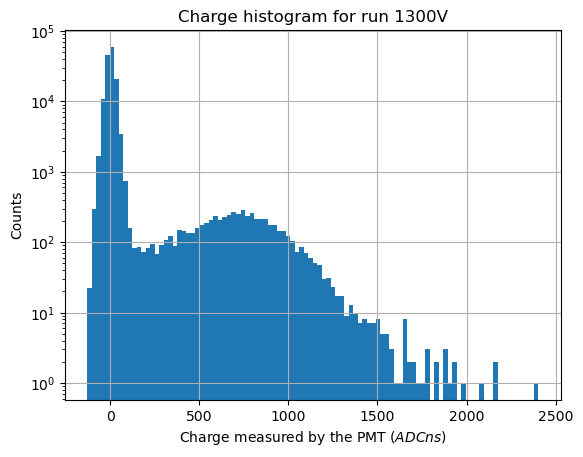

In [12]:
# remove events below -1000, we assume these are duds
adcs = results[1]
plt.hist(adcs, bins = 100)#, range = (1.31875e6,1.321e6))#, range = (-10, 1000))
plt.title('Charge histogram for run 1300V')
#change xlim for integral and peak
#plt.xlim(-200, 3000)
plt.xlabel(r'Charge measured by the PMT ($ADC  ns$)')
plt.ylabel('Counts')
plt.grid()
plt.yscale('log')
#plt.xscale('log')
#plt.axvline(5000, color = 'r')

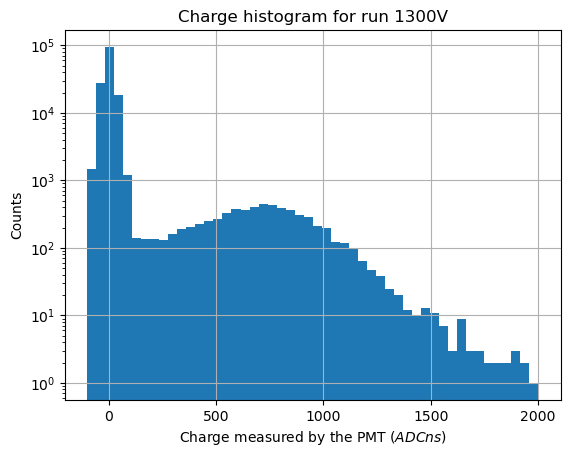

In [13]:
# remove events below -1000, we assume these are duds
adcs = results[1]
plt.hist(adcs, bins = 50, range = (-100, 2000))#, range = (1.31885e6, 1.32e6))
plt.title('Charge histogram for run 1300V')
#change xlim for integral and peak
#plt.xlim(-200, 3000)
plt.xlabel(r'Charge measured by the PMT ($ADC  ns$)')
plt.ylabel('Counts')
plt.grid()
plt.yscale('log')
#plt.xscale('log')
#plt.axvline(5000, color = 'r')

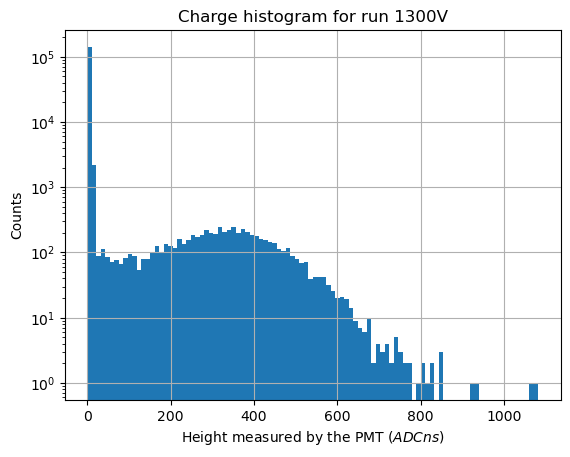

In [14]:
# remove events below -1000, we assume these are duds
adcs = results[2]
plt.hist(adcs, bins = 100)#, range = (57000, 58500))
plt.title('Charge histogram for run 1300V')
#change xlim for integral and peak
#plt.xlim(-200, 3000)
plt.xlabel(r'Height measured by the PMT ($ADC  ns$)')
plt.ylabel('Counts')
plt.grid()
plt.yscale('log')
#plt.xscale('log')
#plt.axvline(5000, color = 'r')

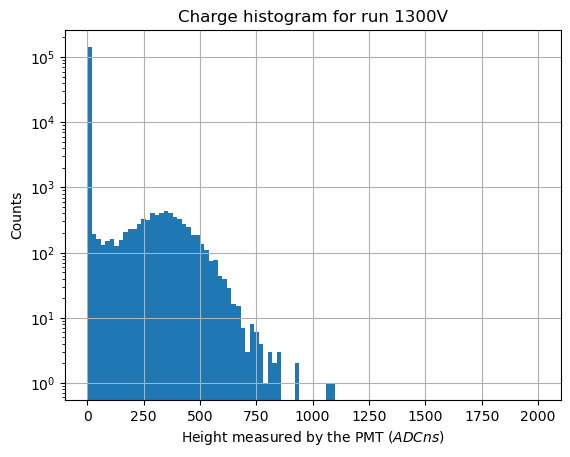

In [15]:
# remove events below -1000, we assume these are duds
adcs = results[2]
plt.hist(adcs, bins = 100, range = (0, 2000))#, range = (57000, 58500))
plt.title('Charge histogram for run 1300V')
#change xlim for integral and peak
#plt.xlim(-200, 3000)
plt.xlabel(r'Height measured by the PMT ($ADC  ns$)')
plt.ylabel('Counts')
plt.grid()
plt.yscale('log')
#plt.xscale('log')
#plt.axvline(5000, color = 'r')

In [41]:
# data with peak_val < 1000 ADCs
results = np.array(results)
threshold_peak = 1000
data_below = results[0][results[1]<threshold_peak]
data_above = results[0][results[1]>threshold_peak]

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (3, 25580) + inhomogeneous part.

In [ ]:
for i in range(100):
    plt.plot(time, data_below[i], alpha = 0.2)
plt.title('WFs below 5000ADCns')
plt.xlabel('Time (us)')
plt.ylabel('Waveform signal (ADC)')

plt.show()

for i in range(10):
    plt.plot(time, data_above[i], alpha = 0.2)
plt.title('WFs above 10000ADCns')
plt.xlabel('Time (us)')
plt.ylabel('Waveform signal (ADC)')

plt.show()